## Qualtiy of neural control reflects local gradient alignment

Here we perform three experiments:
1. Gradient alignment vs. standard linear regression EV as a function of sample size
2. Original strech control objective vs. gradient alignment EV from linear mapping
3. Targeted control objective vs. gradient alignment EV. 

The goal of #1 is to see whether better pointwise function alignment leads to better gradient alignment.
If this is not the case, then this would explan #2. Given these observations we improve upon the control metric's sensitivity to gradient with #3.

In [1]:
import torch
import torchvision.models as models
from util.modelregressions import CNNCrossFit
from util.misc_functions import float2rgb
from dataset.hvm import HVMDataset
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
# load up target and source models
squeezenet_target = models.squeezenet1_0(pretrained=True).features.to(device)
squeezenet_source = models.squeezenet1_1(pretrained=True).features.to(device)
# define basic params 
cnn_layer = 7
source_units = np.arange(256)
target_units = np.arange(256)
img_dim = [256,256,3]
# pre-load data into memory for speed
nimg = 5000;
batch_max = 1;
hvmdataset = HVMDataset(device,nimg)

C:\Users\Chong Guo\AppData\Local\conda\conda\envs\torch\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\Chong Guo\AppData\Local\conda\conda\envs\torch\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [3]:
# create a control experiment (squeezenet1_1-->squeezenet1_0)
snet2snet200 = CNNCrossFit(squeezenet_target,squeezenet_source,cnn_layer,target_units,source_units,device)
# extract layer activation across two models
snet2snet200.design(hvmdataset, batch_size = batch_max, record_gradient = True)

Extracting activations and input jacobians


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [2:22:47<00:00,  1.71s/it]


In [4]:
# linear prediction of target unit, record performance
snet2snet200.fit(round(nimg*.8),round(nimg*.2))


Linear regression from source to target:


100%|██████████████████████████████████████████████████████████████████████████████| 256/256 [1:07:11<00:00, 15.11s/it]


In [5]:
# implement source control of target units, record performance
snet2snet200.control()

Optimizing source to target control:


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:41<00:00,  6.31it/s]


No handles with labels found to put in legend.


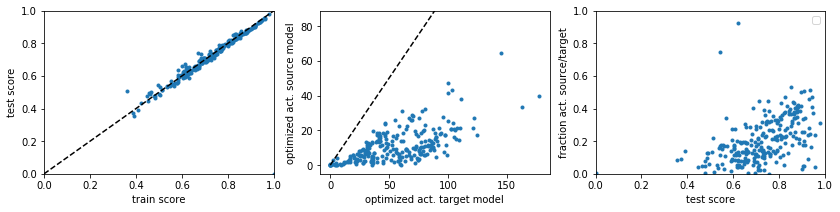

In [15]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
plt.plot(snet2snet200.train_score,snet2snet200.test_score,'.')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim((0,1))
plt.xlabel('train score')
plt.ylabel('test score')
plt.subplot(1,3,2)
plt.plot(snet2snet200.target_act,snet2snet200.source_act,'.')
lmin, lmax = min(snet2snet200.target_act), max(snet2snet200.target_act)
plt.plot([lmin, lmax],[lmin, lmax],'k--')
plt.axis('tight')
plt.ylim((lmin-5,lmax/2))
plt.xlabel('optimized act. target model')
plt.ylabel('optimized act. source model')
plt.subplot(1,3,3)
plt.plot(snet2snet200.test_score,snet2snet200.ctr_score,'.')
plt.legend()
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('test score')
plt.ylabel('fraction act. source/target')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


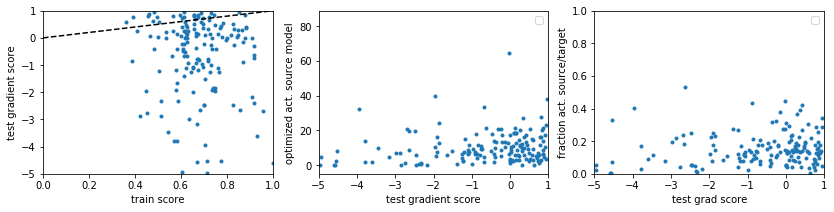

In [66]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
plt.plot(snet2snet200.train_score,snet2snet200.test_gscore,'.')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim((-5,1))
plt.xlabel('train score')
plt.ylabel('test gradient score')
plt.subplot(1,3,2)
plt.plot(snet2snet200.test_gscore,snet2snet200.source_act,'.')
plt.legend()
plt.axis('tight')
plt.xlim((-5,1))
plt.ylim((lmin-5,lmax/2))
plt.xlabel('test gradient score')
plt.ylabel('optimized act. source model')
plt.subplot(1,3,3)
plt.plot(snet2snet200.test_gscore,snet2snet200.ctr_score,'.')
plt.legend()
plt.xlim((-5,1))
plt.ylim((0,1))
plt.xlabel('test grad score')
plt.ylabel('fraction act. source/target')
plt.show()